# Большая лабораторная. Итерация #1

### Постановка задачи
**Вход:** фотографии, на которых изображен объект А — таз пластмассовый 10 л сиреневого цвета, и объект B — стол со столешницей темно-коричневых и бежевых оттенков, имеющий на столешнице набор прямых параллельных линиий, и металлическими глянцевыми ножками в количестве 4 шт. 

Необходимо понять, можно ли поместить объект А, под стол B. «Поместить» означает перемещение объекта А в одной плоскости в область под столешницей стола B без деформации объекта A.

Объект может поместиться под стол, если его размеры меньше, чем расстояние от пола до столешницы. Этому условию таз заранее удовлетворяет. Висеть над столом тазу запрещено: он может только лежать на полу, соприкасаясь или не соприкасаясь с ножками, или же на самой столешнице.
Таким образом, ответ "нет" получаем тогда, когда таз находится _над_ столом или на уровне столешницы. Ответ "да" получаем тогда, когда таз находится _под_ столом (под столешницей).


### Требования к входным данным
1. Формат изображения Joint Photographic Experts Group (.jpeg, .jpg), соотношение сторон 9:16 (горизонтальная ориентация). Минимальный размер изображения 360 х 640.
2. Объекты на фотографии хорошо различимы: резкие, не смазанные, находятся в фокусе, не шумные, отсутствует ретушь; нет пересвеченных или черных областей, цвета естественные.
3. Фон за изучаемыми объектами светлый, контрастный с обоими объектами и их частями. 
4. Пропорции объектов относительно друг друга сохраняются. Объекты находятся на фотографии целиком, т.е. не обрезаются краями изображения. Коллажи из двух и более изображений недопустимы. Оба объекта (стол B и таз А) обязательно присутствуют на изображении. Стол должен находиться близко к стене (фону), большая часть столешницы должна быть параллельна (или почти параллельна) стене.
5. Оптика среднеугольная (fish-eye изображения недопустимы). Изображения имеют небольшое перспективное искажение или не имеют его совсем.

# Решение задачи

### Подготовительные действия

Загрузим тестовые входные данные в два массива: изображения с ответом "да" и изображения с ответом "нет". 

In [1]:
import cv2 as cv
import os

no_path = "data/no"
yes_path = "data/yes"

def read_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

no_data = read_images(no_path) # 9 images
yes_data = read_images(yes_path) # 7 images

Для демонстрации работы программы зададим любое тестовое изображение.

In [2]:
test_image = no_data[0]

### Определение границ объектов, содержащихся на изображении

Используем фильтр Canny с гауссовым ядром. Передавать следующему шагу алгоритма будем также и исходное изображение.

In [3]:
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

def get_canny(img):
    a_gray = rgb2gray(img)
    a_blur = gaussian(a_gray, 1)
    a_edges = canny(a_blur, sigma=0.1, low_threshold=0.1)
    return a_edges

### Распознавание и идентификация найденных объектов

В этом пункте необходимо найти объекты на изображении. Мы точно знаем, что они есть (это требование к входным данным), и теперь нам необходимо верно определить местоположение таза и стола.  
1. Вначале найдем стол. Для этого применим преобразование Хафа для поиска прямых на изображении. Нас интересует крышка стола - это одна или несколько прямых, поскольку крышка стола имеет характерную структуру. 

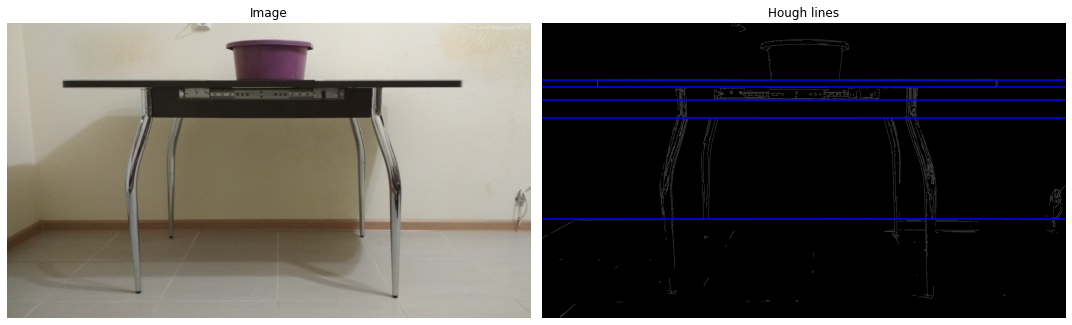

In [4]:
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
from matplotlib import cm

def get_hough_transform(img):
    canny_img = get_canny(img)
    h, theta, d = hough_line(canny_img)
    line_peaks = hough_line_peaks(h, theta, d)
    lines = []
    
    x0 = 0
    x1 = img.shape[1]
    
    for h, angle, dist in zip(*line_peaks):
        y0 = dist / np.sin(angle)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        lines.append((angle, dist, (x0, y0), (x1, y1)))
    
    # сортируем по местоположению по высоте внутри изображения
    lines = sorted(lines, key=lambda x: abs(x[1]), reverse=True)
    return lines

def show_hough(image, lines):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[0].set_title('Image')
    ax[0].set_axis_off()
    

    ax[1].imshow(get_canny(image), cmap=cm.gray)
    for _, _, p0, p1 in lines:
        ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), '-b')
    ax[1].set_xlim((0, image.shape[1]))
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Hough lines')

    plt.tight_layout()

line_peaks = get_hough_transform(test_image)
show_hough(test_image, line_peaks)

Теперь найденные прямые необходимо отфильтровать. Поскольку на фоне находится ярко выраженный плинтус и прямые кафеля, будем удалять одиночные прямые, находящиеся слишком далеко снизу от набора других найденных прямых, поскольку плинтус и кафель могут находиться либо снизу стола, либо перемешиваться с линиями на крышке стола (в этом случае фильтровать не будем). Также удалим прямые, имеющие слишком маленький угол наклона. Предполагаем, что набор прямых крышки стола не имеет резких пересечений (поскольку сильное перспективное искажение запрещено).

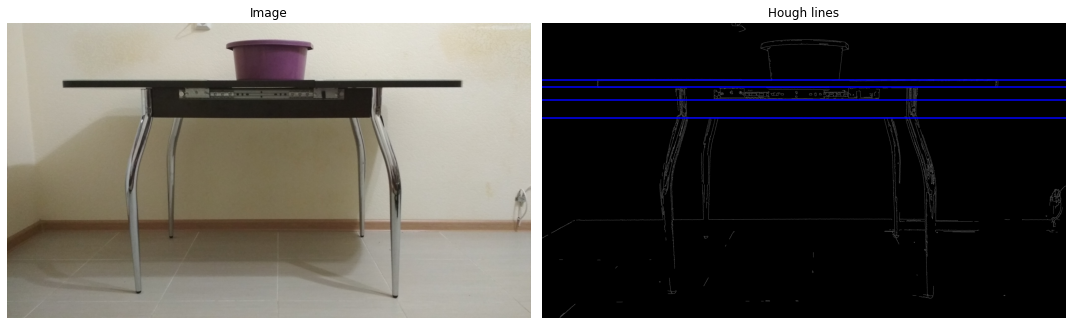

In [5]:
from shapely.geometry import LineString # устанавливается через conda

ALLOWED_ANGLE = 1
ALLOWED_DISTANCE = 400
ALLOWED_TURN = 0.2

# близость прямых

def find_outlier(elem, array):
    flag = 0
    for a in array:
        if abs(abs(int(a[1])) - abs(int(elem[1]))) > ALLOWED_DISTANCE:
            flag += 1
    # вычитаем единицу из-за того, что elem тоже находится в array
    if flag == len(array)-1:
        # если линия еще и самая нижняя, считаем ее куском пола
        if elem == array[0]:
            return False
    return True


# резкое пересечение прямых внутри изображения
# на предложенном датасете функция не понадобится

def find_intersection(elem, array, img):
    height, width = img.shape[:2]
    for a in array:
        if abs(abs(int(elem[0])) - abs(int(a[0]))) > ALLOWED_TURN:
            # проверяем, лежит ли пересечение внутри изображения
            line1 = LineString([a[2], a[3]])
            line2 = LineString([elem[2], elem[3]])
            inter = line1.intersection(line2)
            if (0 < inter.x < width) or (0 < inter.y < height):
                if abs(a[0]) > abs(elem[0]):
                    return elem
                else:
                    return a
    return None
                

def remove_noise(line_peaks, img):   
    new_lines = line_peaks.copy()
    
    # удаляем прямые по углу поворота
    for line in line_peaks:
        if abs(line[0]) <= ALLOWED_ANGLE:
            new_lines.remove(line)
    
    lines_copy = new_lines.copy()
    
    # удаляем прямые плинтуса/кафеля
    for line in line_peaks:
        if line in new_lines:
            if not find_outlier(line, lines_copy):
                new_lines.remove(line)

    # убираем оставшиеся пересекающиеся прямые
    for line in line_peaks:
        if line in new_lines:
            inter = find_intersection(line, new_lines, img)
            if inter and inter in new_lines:
                new_lines.remove(inter)
    
    return new_lines

new_lines = remove_noise(line_peaks, test_image)
show_hough(test_image, new_lines)

Итак, прямые, задающие стол, найдены. 

In [6]:
if not new_lines:
    print("К сожалению, стол не найден. Попробуйте другое изображение")
else:
    # задаем стол как самую нижнюю из оставшихся прямых
    table = new_lines[0]

2. Теперь необходимо найти таз. Известно, что он сиреневого цвета, поэтому будем искать его бинаризацией по оттенкам сиреневого.

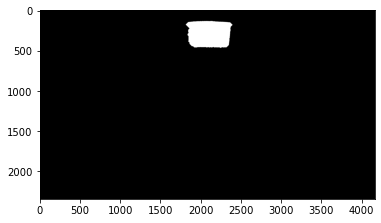

In [7]:
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes
from skimage.measure import label, regionprops

LILAC_MIN = np.array([60, 50, 41],np.uint8)
LILAC_MAX = np.array([179, 255, 255],np.uint8)

# найдем наибольший контур

def get_mask(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    color_range = cv.inRange(hsv_img, LILAC_MIN, LILAC_MAX)
    
    mask = binary_closing(color_range, iterations = 3)
    img_segment = binary_fill_holes(mask)
    mask_img = binary_opening(img_segment, iterations = 30)
    
    # возьмем наибольший, а остальные удалим
    
    int_mask = label(mask_img)
    regions = regionprops(int_mask)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)
    
    if len(regions) > 1:
        for r in regions[1:]:
            int_mask[r.coords[:,0], r.coords[:,1]] = 0
    
    int_mask[int_mask!=0] = 1
    
    return int_mask


mask = get_mask(test_image)
if any(1 in i for i in mask):
    plt.imshow(mask, cmap = cm.gray)
else:
    print("К сожалению, таз не найден. Попробуйте другое изображение")

Маска таза найдена. Теперь нужно определить координаты ее верхней и нижней частей, а также найти ограничивающий таз прямоугольник.

In [8]:
def get_bowl_properties(mask):
    contours, _ = cv.findContours(mask, 1, 2)
    cnt = contours[0]
    # ограничивающий прямоугольник
    rect = cv.minAreaRect(cnt)
    # верхняя и нижняя экстремальные точки
    max_p = tuple(cnt[cnt[:,:,1].argmin()][0])
    min_p = tuple(cnt[cnt[:,:,1].argmax()][0])
    
    return max_p, min_p, rect

new_mask = mask.astype(np.uint8)
bowl = get_bowl_properties(new_mask)

### Определение взаимного расположения объектов. Ответ на поставленный вопрос

Имеется таз, заданный экстремальными координатами и ограничивающим прямоугольником, и стол, заданный нижней прямой столешницы (по двум точкам этой прямой).  

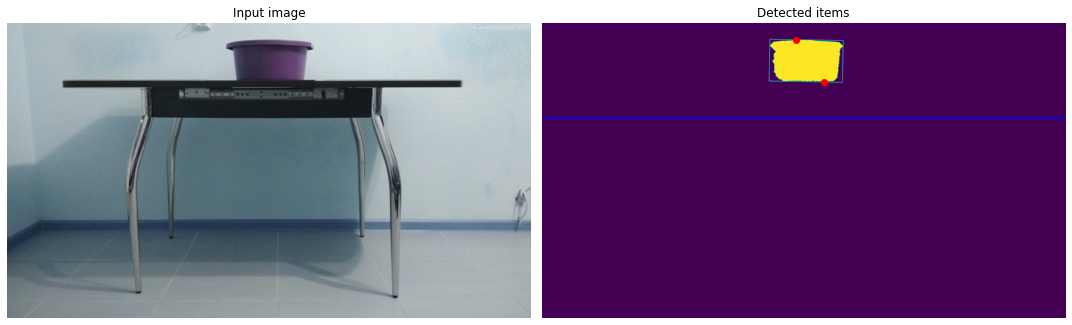

In [9]:
box = np.int0(cv.boxPoints(bowl[2]))
cv.drawContours(new_mask, [box], 0, (1, 0, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].imshow(test_image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(new_mask)
ax[1].plot(bowl[0][0], bowl[0][1], 'ro')
ax[1].plot(bowl[1][0], bowl[1][1], 'ro')
ax[1].set_xlim((0, test_image.shape[1]))
ax[1].set_ylim((test_image.shape[0], 0))

_, _, p0, p1 = table
ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), '-b')
ax[1].set_axis_off()
ax[1].set_title('Detected items')

plt.tight_layout()

Если таз полностью ниже прямой - считаем, что ответ на поставленный вопрос положительный.  
Если таз полностью выше прямой - отрицательный.  
Если таз пересекается с прямой, необходимо посчитать, какая часть таза находится над ней. Если больше 75% - ответ отрицательный (таким образом мы надеемся, что распознанная прямая все-таки не плинтус). Иначе - положительный.

In [10]:
from shapely.geometry import Polygon
from scipy.spatial import distance as dist

ALLOWED_PERCENTAGE = 0.75

def side_of_line(p1, p2, point):
    x, y = point
    x1, y1 = p1
    x2, y2 = p2
    return (x-x1)*(y2-y1) - (y-y1)*(x2-x1)

def line_crossing(box, p1, p2):
    line = LineString([p1, p2])
    intersect = Polygon(box).intersection(line)
    
    if intersect:
        return intersect.coords[:]
    else:
        return None
    

def trapezoid_area(rect, p1, p2):
    # находим координаты пересечения линии с ограничивающим прямоугольником
    box = np.int0(cv.boxPoints(rect))
    box_tuples = [tuple(elem) for elem in box]
    l1, l2 = line_crossing(box_tuples, p1, p2)
    
    # координаты линии зададим против часовой стрелки
    # поскольку box_tuples тоже против часовой стрелки  
    polygon = [l2, l1]
    
    # находим координаты многоугольника, отсекаемого прямой
    for p in box_tuples:
        if side_of_line(l1, l2, p) > 0:
            polygon.append(p)

    # находим площадь многоугольника
    poly = Polygon(polygon)
    return poly.area


def get_answer(table, bowl):
    angle, dist, p1, p2 = table
    max_p, min_p, rect = bowl
    
    if side_of_line(p1, p2, min_p) >= 0:
        return False
    elif side_of_line(p1, p2, max_p) <= 0:
        return True
    else:
        # на предложенном датасете функция не понадобится
        center, wh, angle = rect
        w, h = wh
        area = w*h
        trapezoid = trapezoid_area(rect, p1, p2)
        if area*ALLOWED_PERCENTAGE <= trapezoid:
            return False
        else:
            return True

def print_answer(answer):
    if answer:
        print("Таз можно поместить под стол")
    else:
        print("Таз нельзя поместить под стол")

answer = get_answer(table, bowl)
print_answer(answer)

Таз нельзя поместить под стол


Проверим оба датасета.

In [11]:
def check_data(data):
    for d in data:
        peaks = get_hough_transform(d)
        table_lines = remove_noise(peaks, d)
        tbl = table_lines[0]
        
        bowl_mask = get_mask(d)
        clean_mask = bowl_mask.astype(np.uint8)
        bwl = get_bowl_properties(clean_mask)
        ans = get_answer(tbl, bwl)
        print_answer(ans)

print("Проверка датасета с ответом 'нет':")
check_data(no_data)
print("\nПроверка датасета с ответом 'да':")
check_data(yes_data)

Проверка датасета с ответом 'нет':
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол
Таз нельзя поместить под стол

Проверка датасета с ответом 'да':
Таз можно поместить под стол
Таз можно поместить под стол
Таз можно поместить под стол
Таз можно поместить под стол
Таз можно поместить под стол
Таз можно поместить под стол
Таз можно поместить под стол


__Готово! Вы восхитительны!__